# Homework 2
**Daniel McAllister-Ou | DBM2397**

Two wells have been completed in a new oil reservoir but have not yet been put on stream.  The initial pressure is 3808 psia at datum in both wells, which are 185 m (607 ft) apart horizontally.

Before bringing the wells on stream, tests were performed to determine the reservoir properties between the two wells and to evaluate the need for stimulation.  Well 1 was produced for 96 hours at an average rate of 82.5 m³/d (519 stb/d).  Draw down pressures were measured in Well 1.  Pressures were also monitored in Well 2, which was shut-in. Well 1 was then shut-in at the surface for 72 hours during which time the build-up pressure was recorded.

### Task
•	Analyze the drawdown data from Well 1 using a Horner plot to determine permeability and skin.


In [658]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'

Read data

   time - hr  BHP - psia
0     0.0000        3808
1     0.0334        3803
2     0.0688        3798
3     0.1000        3792
4     0.1330        3788


<Axes: xlabel='time - hr', ylabel='BHP - psia'>

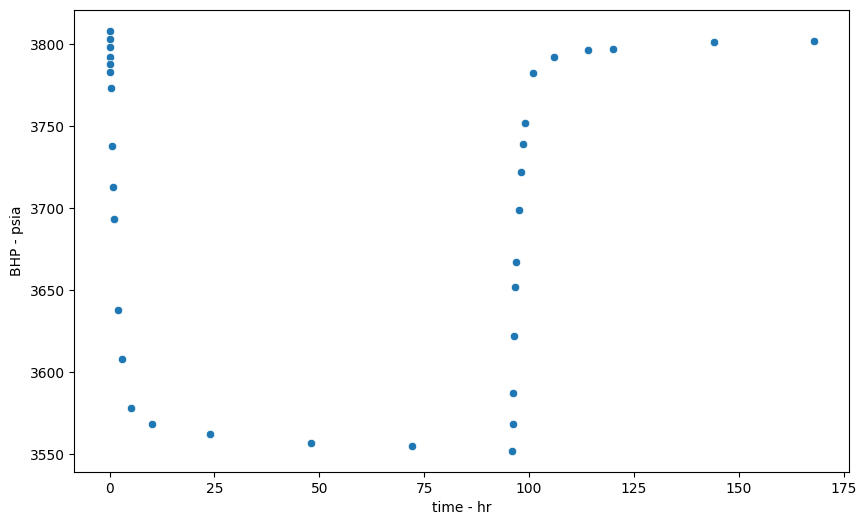

In [659]:
data = pd.read_excel(r'C:\Users\txjam\Documents\homework\well_testing\REFund_oil_welltest_HW2.XLSX', skiprows=1, usecols="B:C")
print(data.head())

fig,ax = plt.subplots(figsize=(10,6))
sns.scatterplot(data=data, x='time - hr', y='BHP - psia', ax=ax)

We need to find $$\frac{t_p + \Delta t}{\Delta t}$$ for our Horner plot where Tp is shut-in time and delta t is time since


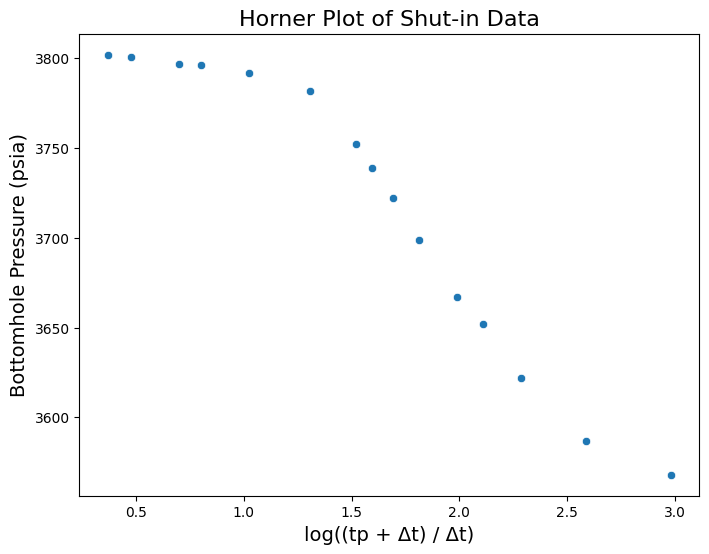

In [660]:
time_when_shut = 96
full_data = data.copy()
shutin_data = data[data['time - hr'] > time_when_shut]
shutin_data['delta T'] = shutin_data['time - hr'] - time_when_shut
shutin_data['Horner Time'] = (time_when_shut + shutin_data['delta T']) / shutin_data['delta T']
shutin_data['log Horner Time'] = np.log10(shutin_data['Horner Time'])
shutin_data['Pws'] = shutin_data['BHP - psia']

fig,ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=shutin_data, x='log Horner Time', y='Pws', ax=ax)
ax.set_title('Horner Plot of Shut-in Data', fontsize=16)
ax.set_xlabel('log((tp + Δt) / Δt)', fontsize=14)
ax.set_ylabel('Bottomhole Pressure (psia)', fontsize=14)
plt.show()



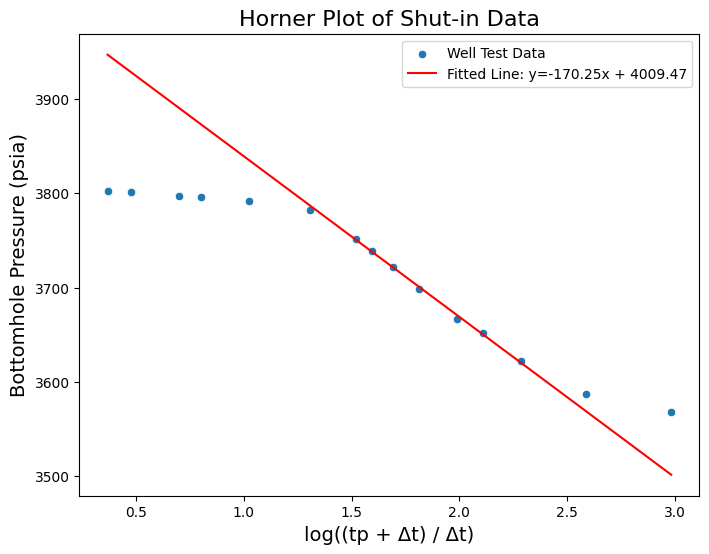

In [661]:
straight_line_data = shutin_data[(shutin_data['log Horner Time'] > 1.4) & (shutin_data['log Horner Time'] < 2.5)]
slope, intercept = np.polyfit(straight_line_data['log Horner Time'], straight_line_data['Pws'], 1)
pstar = intercept
shutin_data['Fitted Pws'] = slope * shutin_data['log Horner Time'] + intercept

fig,ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=shutin_data, x='log Horner Time', y='Pws', ax=ax,label='Well Test Data')
sns.lineplot(data=shutin_data, x='log Horner Time', y='Fitted Pws', ax=ax, color='red', label=f'Fitted Line: y={slope:.2f}x + {intercept:.2f}')
ax.set_title('Horner Plot of Shut-in Data', fontsize=16)
ax.set_xlabel('log((tp + Δt) / Δt)', fontsize=14)
ax.set_ylabel('Bottomhole Pressure (psia)', fontsize=14)
plt.legend()
plt.show()

Now we will calculate permeability and skin

In [662]:
p1hr = slope * np.log10((time_when_shut + 1) / 1) + intercept
print(f'Extrapolated Pressure at 1 hour after shut-in: {p1hr:.2f} psia')
pwf = full_data[full_data['time - hr'] == time_when_shut]['BHP - psia'].values[0]
print(f'Pressure at shut-in: {pwf:.2f} psia')

q = 519 # stb/d
mu = 0.92 # cp
rw = 0.27 # ft
h = 13 # ft
Bo = 1.06 # rb/stb
ct = 13e-6 # psi-1
phi = 0.22 # fraction
Pi = 3808 # psia

def estimate_permeability(slope, q, mu, Bo, h):
    k = (162.6 * q * mu * Bo) / (slope * h)
    return k

def estimate_skin(pwf, p1hr, k, h, rw, q, mu, Bo, slope):
    s = 1.151 * ( (p1hr - pwf)/slope - np.log10(k/phi/mu/ct/rw**2) + 3.23 )
    return s

k = estimate_permeability(-slope, q, mu, Bo, h)
s = estimate_skin(pwf, p1hr, k, h, rw, q, mu, Bo, slope)

print(f'Estimated Permeability: {k:.2f} md')
print(f'Estimated Skin Factor: {s:.2f}')

Extrapolated Pressure at 1 hour after shut-in: 3671.22 psia
Pressure at shut-in: 3552.00 psia
Estimated Permeability: 37.18 md
Estimated Skin Factor: -6.63


To find average reservoir pressure we need to know drainage area. I will attempt to do this from drawdown data

Estimated Drainage Area from PSS analysis: 596.04 acres


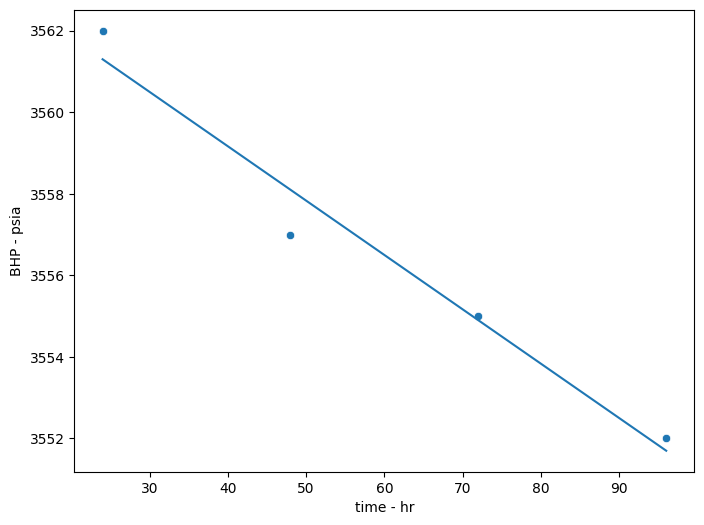

In [663]:
drawdown_data = full_data[full_data['time - hr'] <= time_when_shut]
late_time_drawdown = drawdown_data[drawdown_data['time - hr'] > 20]

fig,ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=late_time_drawdown, x='time - hr', y='BHP - psia', ax=ax)
pwf_times = late_time_drawdown['time - hr'].tolist()
pwf_values = late_time_drawdown['BHP - psia'].tolist()

slope, intercept = np.polyfit(np.array(pwf_times), np.array(pwf_values), 1)
PV_rb = -(q * Bo) / (24.0 * ct * slope)
A_hat_acres = PV_rb * 5.615 / (43560.04 * h * phi)
print(f'Estimated Drainage Area from PSS analysis: {A_hat_acres:.2f} acres')

gamma = 1.781
dp_const_psia = Pi - intercept
F = (k * h / (141.2 * q * Bo * mu)) * dp_const_psia  # dimensionless
A_hat_ft2 = A_hat_acres * 43560.04
late_time_drawdown['Fitted Pws'] = slope * late_time_drawdown['time - hr'] + intercept
sns.lineplot(data=late_time_drawdown, x='time - hr', y='Fitted Pws', ax=ax)
C_A_hat = (4.0 * A_hat_ft2) / (gamma * rw**2 * np.exp(2.0 * F))

# print(f'Estimated Shape Factor from PSS analysis: {C_A_hat:.2f}')

Begin MBH analysis

In [664]:
def find_Tda(k,t,phi,mu,ct,A):
    return 0.000264 * k * t / phi / mu / ct / A

Tda = find_Tda(k,96+72,phi,mu,ct,A_hat_ft2)
print(f'Estimated Dimensionless Time Tda: {Tda:.2f}')

Estimated Dimensionless Time Tda: 0.02


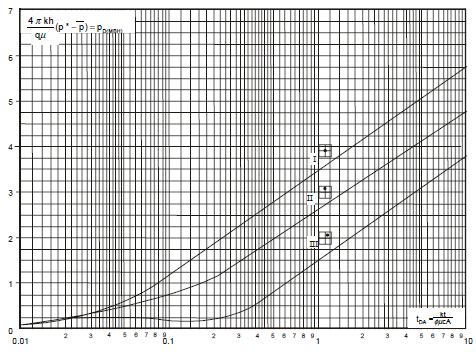


In [665]:
Pd_mbh = 0.022 
# .01416 * k*h / (q * Bo * mu) * (avgresP - Pstar) = 0.022
avgresP = (Pd_mbh * q * Bo * mu) / (0.01416 * k * h) + pstar
print(f'Estimated Average Reservoir Pressure: {avgresP:.2f} psia')


Estimated Average Reservoir Pressure: 4011.09 psia


Derivative plot analysis

C:\Users\txjam\AppData\Roaming\Python\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


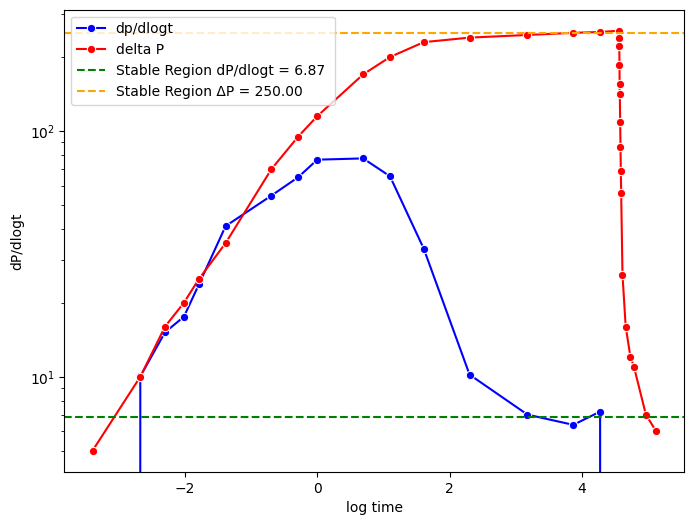

In [666]:
# deriv_data = full_data[full_data['time - hr'] > time_when_shut]
deriv_data = full_data.copy()
deriv_data['log time'] = np.log(deriv_data['time - hr'])
deriv_data['delta P'] = Pi - deriv_data['BHP - psia']  
dP = deriv_data['delta P'].values
logt = deriv_data['log time'].values
dP_dlogt = np.full(len(dP), np.nan)

for i in range(1, len(dP)-1):
    dP_dlogt[i] = (dP[i+1] - dP[i-1]) / (logt[i+1] - logt[i-1])

stable_region_dP = dP_dlogt[(deriv_data['log time'] > 3.17) & (deriv_data['log time'] < 4.28)].mean()
stable_region_pres = deriv_data['delta P'][(deriv_data['log time'] > 3.17) & (deriv_data['log time'] < 4.28)].mean()

deriv_data['dP/dlogt'] = dP_dlogt
fig,ax = plt.subplots(figsize=(8,6))
sns.lineplot(data=deriv_data, x='log time', y='dP/dlogt', ax=ax, color = 'b', marker = 'o', alpha =1, label = 'dp/dlogt')
sns.lineplot(data=deriv_data,x='log time', y = 'delta P', ax=ax, color = 'r',marker='o', label = 'delta P')
# sns.scatterplot(data=deriv_data[(deriv_data['log time'] > 3.17) & (deriv_data['log time'] < 4.28)], 
#                 x='log time', y='dP/dlogt', ax=ax, color='g', label='Stable Region Points')

ax.axhline(stable_region_dP, color='g', linestyle='--', label=f'Stable Region dP/dlogt = {stable_region_dP:.2f} ')
ax.axhline(stable_region_pres, color='orange', linestyle='--', label=f'Stable Region ΔP = {stable_region_pres:.2f} ')

plt.legend()
ax.set_yscale('log')

In [667]:
avg_stable_time_log = (3.17 + 4.28) / 2
avg_stable_time = np.exp(avg_stable_time_log)

kh_est = 70.6 * q * mu * Bo / stable_region_dP
print(f'Estimated k*h from Derivative Plot Analysis: {kh_est:.2f}')
print(f'Estimated k from Derivative Plot Analysis: {kh_est/h:.2f} md')
der_est_s = 0.5 * ( (stable_region_pres / stable_region_dP) - np.log(k*avg_stable_time/1688/phi/mu/ct/rw**2))
print(f'Estimated Skin from Derivative Plot Analysis: {der_est_s:.2f}')

Estimated k*h from Derivative Plot Analysis: 5204.37
Estimated k from Derivative Plot Analysis: 400.34 md
Estimated Skin from Derivative Plot Analysis: 10.52


Estimated k and skin from derivative plot is much higher than what was estimated by horner 